# Linear model try
V1.0  
This version is a first build-up of the whole system. 

V2.0  
This version added "central extraction", in which we only extract the central (0.3~0.9) part of videos for testing set.  
In this way, we try to avoid recognizing frames at the beginning and end of the videos that are not the target gesture as much as possible.  
尽可能避免前后识别出来但不是目标手势的帧

### Import Libs

In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
import os
import numpy as np
import matplotlib.pyplot as plt

from model_dataset import HandshapeDataset, DS_Tools
from paths import *
from model_model import HandshapePredictor
from model_configs import *
from utils import *
from recorder import *

## Init Model

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
model = HandshapePredictor(
    input_dim=in_dim, 
    enc_lat_dims=enc_lat_dims, 
    hid_dim=hid_dim, 
    dec_lat_dims=dec_lat_dims, 
    output_dim=out_dim
)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Initialize model params

In [3]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.orthogonal_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

HandshapePredictor(
  (encoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=63, out_features=32, bias=True)
      (relu): ReLU()
    )
    (1): LinPack(
      (lin): Linear(in_features=32, out_features=16, bias=True)
      (relu): ReLU()
    )
    (2): LinPack(
      (lin): Linear(in_features=16, out_features=8, bias=True)
      (relu): ReLU()
    )
    (3): Linear(in_features=8, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=5, out_features=16, bias=True)
      (relu): ReLU()
    )
    (1): LinPack(
      (lin): Linear(in_features=16, out_features=32, bias=True)
      (relu): ReLU()
    )
    (2): Linear(in_features=32, out_features=93, bias=True)
  )
)

### Check number of params in model

In [4]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

6466


## Prepare for logs

In [5]:
# Just for keeping records of training hists. 
ts = str(get_timestamp())
# ts = "0918192113"
stop_epoch = "149"
save_txt_name = "train_txt_{}.hst".format(ts)
save_trainhist_name = "train_{}.hst".format(ts)
save_valhist_name = "val_{}.hst".format(ts)
save_valacc_name = "valacc{}.hst".format(ts)

valid_losses = LossRecorder(model_save_dir + save_valhist_name)
train_losses = LossRecorder(model_save_dir + save_trainhist_name)
valid_accuracies = LossRecorder(model_save_dir + save_valacc_name)
text_hist = HistRecorder(model_save_dir + save_txt_name)

print("NOTE: {} is the series number this time. ".format(ts))

NOTE: 0920201303 is the series number this time. 


### Switch for loading saved records

In [6]:
READ = False
# READ = True

if READ: 
    valid_losses.read()
    train_losses.read()
    valid_accuracies.read()

    model_raw_name = "CP_{}_{}".format(ts, stop_epoch)
    model_name = model_raw_name + ".pt"
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)
    model.load_state_dict(state)
    model.to(device)

## Dataset and Dataloader

### Data and Tag Paths

In [7]:
data_path = os.path.join(data_dir, data_name + "_data.npz")
tag_path = os.path.join(data_dir, data_name + "_tag.npz")

### Create Dataset

In [8]:
ds = HandshapeDataset(data_path, tag_path)
if READ: 
    valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid_ds_{}.pkl".format(ts)))
    all_indices = list(range(len(ds)))
    train_ds_indices = list(set(all_indices).difference(set(valid_ds_indices)))

    train_ds = torch.utils.data.Subset(ds, train_ds_indices)
    valid_ds = torch.utils.data.Subset(ds, valid_ds_indices)
else: 
    train_len = int(0.8 * len(ds))
    valid_len = len(ds) - train_len

    # Randomly split the dataset into train and validation sets
    train_ds, valid_ds = random_split(ds, [train_len, valid_len])
    DS_Tools.save_indices(os.path.join(model_save_dir, "valid_ds_{}.pkl".format(ts)), valid_ds.indices)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKER)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER)
valid_num = len(valid_loader.dataset)


### Check size of dataset

In [9]:
print(train_num, valid_num)

15625 3907


## Training

### Define validation set cut range

In [10]:
# cut_range = (0, 0.9)
cut_range = None

In [11]:
BASE = 0
EPOCHS = 200

In [12]:
def train(): 
    for epoch in range(BASE, BASE + EPOCHS):
        text_hist.print("Epoch {}".format(epoch))
        model.train()
        train_loss = 0.
        train_num = len(train_loader)    # train_loader
        for idx, (x, tags) in enumerate(train_loader):
            optimizer.zero_grad()

            x = x.to(device)
            x = x.to(torch.float32)
            tags = tags.to(device)
            
            preds = model(x)

            loss = criterion(preds, tags)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if idx % 100 == 0:
                text_hist.print(f"Training loss {loss: .3f} in Step {idx}")

        train_losses.append(train_loss / train_num)
        text_hist.print(f"※※※Training loss {train_loss / train_num: .3f}※※※")

        last_model_name = "CP_{}_{}.pt".format(ts, epoch)
        torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))
        text_hist.print("Training timepoint saved")

        model.eval()
        valid_loss = 0.
        valid_correct = 0
        valid_total = 0
        valid_num = len(valid_loader)
        for idx, (x, tags) in enumerate(valid_loader):
            x = DS_Tools.cut_frames(x, cut_range=cut_range)
            tags = DS_Tools.cut_frames(tags, cut_range=cut_range)

            x = x.to(device)
            x = x.to(torch.float32)
            tags = tags.to(device)
            preds = model(x)    # (B, C)

            loss = criterion(preds, tags)

            valid_loss += loss.item()


            predicted = torch.argmax(nn.Softmax(dim=1)(preds), dim=1)
            valid_total += tags.size(0)
            valid_correct += (predicted == tags).sum().item()

            if idx % 100 == 0:
                # \t Recon {recon / batch: .3f} \t KL {kl / batch: .3f}
                text_hist.print(f"Valid loss {loss: .3f} in Step {idx}")

        valid_losses.append(valid_loss / valid_num)
        valid_accuracies.append((100 * valid_correct / valid_total))
        text_hist.print(f"※※※Valid loss {valid_loss / valid_num: .3f}※※※")
        text_hist.print(f"※※※Valid accuracy {(100 * valid_correct / valid_total): .3f} %※※※")

In [13]:
if __name__ == "__main__": 
    train()

Epoch 0
Training loss  4.538 in Step 0
Training loss  3.634 in Step 100
Training loss  3.573 in Step 200
Training loss  3.602 in Step 300
Training loss  3.314 in Step 400
※※※Training loss  3.623※※※
Training timepoint saved
Valid loss  3.470 in Step 0
Valid loss  3.570 in Step 100
※※※Valid loss  3.532※※※
※※※Valid accuracy  10.878 %※※※
Epoch 1
Training loss  3.769 in Step 0
Training loss  3.491 in Step 100
Training loss  3.618 in Step 200
Training loss  3.696 in Step 300
Training loss  3.474 in Step 400
※※※Training loss  3.511※※※
Training timepoint saved
Valid loss  3.409 in Step 0
Valid loss  3.532 in Step 100
※※※Valid loss  3.521※※※
※※※Valid accuracy  10.878 %※※※
Epoch 2
Training loss  3.508 in Step 0
Training loss  3.502 in Step 100
Training loss  3.494 in Step 200
Training loss  3.589 in Step 300
Training loss  3.499 in Step 400
※※※Training loss  3.505※※※
Training timepoint saved
Valid loss  3.409 in Step 0
Valid loss  3.520 in Step 100
※※※Valid loss  3.514※※※
※※※Valid accuracy  10.8

In [14]:
### Save
valid_losses.save()
valid_accuracies.save()
train_losses.save()
text_hist.save()

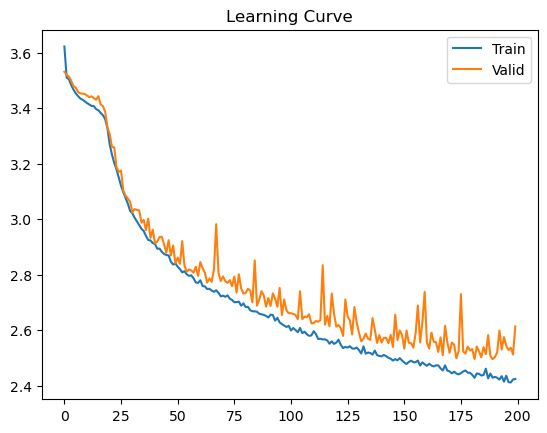

In [15]:
plt.plot(train_losses.get(), label='Train')
plt.plot(valid_losses.get(), label='Valid')
plt.title("Learning Curve")
plt.legend()

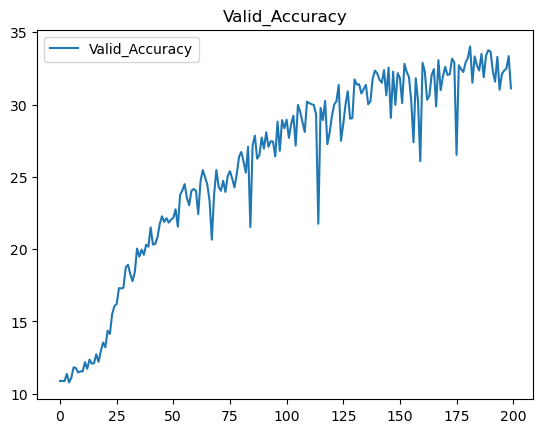

In [17]:
plt.plot(valid_accuracies.get(), label='Valid_Accuracy')
plt.title("Valid_Accuracy")
plt.legend()